In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from itertools import product
from matplotlib import pyplot
import sklearn.datasets as skd
from distance_correlation import *
# Define functions for the differential entropies
#def entropy_marginal(density, support):
#    return -np.trapz(density * np.log2(density), support)

#def entropy_joint(joint_density, support_x, support_y):
    # For joint entropy, we need a double integral, approximated here by a 2D trapezoidal rule
#    return -np.trapz(np.trapz(joint_density * np.log2(joint_density), support_x, axis=0), support_y)
def gauss_legendre(n, a, b):
    """
    Calculate n-point Gauss-Legendre quadrature within [a, b]

    Parameters:
    n(int): Number of quadrature points.
    a(float): Lower bound of integration.
    b(float): Upper bound of integration.

    Returns:
    p(ndarray): Quadrature points.
    w(ndarray): Quadrature weights.
    """
    m = int(np.ceil(n / 2.0))
    x = np.zeros(n)
    w = np.zeros(n)

    for ii in range(1, m + 1):
        z = np.cos(np.pi * (ii - 0.25) / (n + 0.5))
        z1 = z + 1
        while abs(z - z1) > 1e-10:
            p1 = 1.0
            p2 = 0.0
            for jj in range(1, n + 1):
                p3 = p2
                p2 = p1
                p1 = ((2 * jj - 1) * z * p2 - (jj - 1) * p3) / jj
            pp = n * (z * p1 - p2) / (z**2 - 1)
            z1 = z
            z = z1 - p1 / pp
        
        x[ii - 1] = -z
        x[-ii] = z
        w[ii - 1] = 2 / ((1 - z**2) * pp**2)
        w[-ii] = w[ii - 1]

    # Scale the nodes and weights to the interval [a, b]
    p = (b - a) / 2 * x + (b + a) / 2
    w = (b - a) / 2 * w

    return p, w

def GLJointNW(M, N, a, b, c, d):
    """
    Gauss-Legendre method to generate nodes and weights for double
    integration.
    
    Parameters:
    - M, N: Number of points for the quadrature in each dimension.
    - a, b: Integration limits for the first variable.
    - c, d: Integration limits for the second variable.
    
    Returns:
    - A numpy array of shape (M * N, 3) with:
      - The first column being the variable x_p within integration range {a, b}.
      - The second column being the variable x_q within integration range {c, d}.
      - The third column being the joint weights W_pq accounting for the integral ranges.
    """
    # gauss_legendre is defined elsewhere to return nodes and weights
    x_p, w_p = gauss_legendre(M, a, b)
    y_q, w_q = gauss_legendre(N, c, d)
    
    # Initialize the output array
    Gauss_points_weights = np.zeros((M * N, 3))
    
    # Fill in the output array
    counter = 0
    for i in range(M):
        for j in range(N):
            Gauss_points_weights[counter] = [x_p[i], y_q[j], w_p[i] * w_q[j]]
            counter += 1
    
    return Gauss_points_weights

def GLJointNW_general(N, Lower, Upper):
    """
    General Gauss-Legendre method to generate nodes and weights for multiple integration,
    applicable in numerical integration tasks across multiple dimensions.
    
    Parameters:
    - N (list of int): Number of Gauss-Legendre quadrature points for each dimension.
    - Lower (list of float): Lower bounds of integration for each dimension.
    - Upper (list of float): Upper bounds of integration for each dimension.
    
    Returns:
    1. Gauss_points_weights (numpy array): A multi-dimensional grid for numerical integration.
       - Shape: (prod(N), len(N)+1). 
       - Contains variables x_i within [Lower[i], Upper[i]] for each ith dimension and the last
         column contains the joint weights W_p... for integral calculations.
    2. GLpw (list of tuples): Contains nodes (Gauss points) and weights for each dimension,
       useful for separate or joint variable integration.
       - Each tuple: (Gauss points, weights) for individual dimension integration.
       
    Example:
    To integrate a 2D function over [0,1]x[0,1] with 10 points in each dimension:
        N, Lower, Upper = [10, 10], [0, 0], [1, 1]
        points_weights, individual_components = GLJointNW_general(N, Lower, Upper)
    """
    GLpw = []
    for node_num, lower, upper in zip(N, Lower, Upper):
        x_p, w_p = gauss_legendre(node_num, lower, upper)
        GLpw.append((x_p, w_p))
    
    # Initialize the output array
    num_dims = len(N)
    total_points = np.prod(N)
    Gauss_points_weights = np.zeros((total_points, num_dims + 1))
    
    # Generate all combinations of indices for the nodes
    indices = [range(len(x_p[0])) for x_p in GLpw]
    
    # Iterate over all combinations of nodes
    for idx, index_combination in enumerate(product(*indices)):
        # Compute the product of weights for the current combination
        weight_product = np.prod([GLpw[dim][1][i] for dim, i in enumerate(index_combination)])
        
        # Store the nodes for each dimension and the weight product
        node_values = [GLpw[dim][0][i] for dim, i in enumerate(index_combination)]
        Gauss_points_weights[idx, :-1] = node_values
        Gauss_points_weights[idx, -1] = weight_product
    
    return Gauss_points_weights,GLpw

def GL_entropy(density,weight,e=1e-12):
    """
    Numerical estimation of entropy using Gaussian quadrature.

    Parameters:
    - density (numpy array): A 1D array of density values obtained by evaluating the KDE function
                             at Gauss-Legendre quadrature points. These could represent the density
                             of a single variable or joint densities of multiple variables.
    - weight (numpy array): A 1D array of Legendre weights corresponding to the quadrature points.
                            The size of this array must match that of the `density` array.
    - e (float): A small correction term added to density values before taking the logarithm to 
                 ensure numerical stability. This prevents undefined log2(0) calculations and is 
                 particularly useful when density values are very close to or are zero, which can occur 
                 with narrow KDE bandwidth or when estimating joint densities.

    Returns:
    - Entropy (float): The estimated differential entropy based on the provided densities and weights.
                       This can represent marginal entropy if the input densities are for a single variable,
                       or joint entropy if the densities are for joint distributions of multiple variables.

    Example:
        density = kde_function(gauss_points)  # kde_function is your KDE estimation function
        weight = gauss_legendre_weights
        entropy = GL_entropy(density, weight)
    """
    adjusted_density = np.maximum(density, e)
    return -(adjusted_density * np.log2(adjusted_density)*weight).sum()

def GL_KLD(kdex, kdey, p, w, e=1e-12):
    """
    Estimate the Kullback-Leibler Divergence (KLD) between two distributions
    using Gaussian quadrature and kernel density estimates (KDE).

    Parameters:
    - kdex (function): KDE for distribution P, should accept an array of points.
    - kdey (function): KDE for distribution Q, should accept an array of points.
    - p (numpy array): Points at which KDEs are evaluated, obtained from Gaussian quadrature.
    - w (numpy array): Weights associated with the quadrature points.
    - e (float): Small constant to avoid log2(0), ensuring numerical stability.

    Returns:
    - KLD (float): The estimated Kullback-Leibler Divergence from P to Q in bits.
    """
    px = kdex(p)
    adj_px = np.maximum(px, e)  # Adjust density from P to avoid log2(0)
    py = kdey(p)
    adj_py = np.maximum(py, e)  # Adjust density from Q to avoid log2(0)

    # Calculate the KLD
    return ((adj_px * (np.log2(adj_px) - np.log2(adj_py))) * w).sum()

def GL_MI(kdex, kdey, kdexy, Gauss_points_weights, e=1e-12):
    """
    Numerical estimation of mutual information (MI) between two variables using 
    Gaussian quadrature and kernel density estimation (KDE).
    
    Parameters:
    - kdex (function): KDE function for the first variable X. This function should
                       accept a numpy array of points and return the estimated 
                       density at those points.
    - kdey (function): KDE function for the second variable Y, similar to `kdex`.
    - kdexy (function): Joint KDE function for variables X and Y. This function 
                        should accept a 2D numpy array of points (each row is a point 
                        in the joint space of X and Y) and return the estimated joint 
                        density at those points.
    - Gauss_points_weights (numpy array): An array containing the Gauss-Legendre 
                                          quadrature points and weights. The last 
                                          column should contain the weights, and the 
                                          other columns the quadrature points for 
                                          each dimension.
    - e (float): A small positive value to ensure numerical stability by preventing
                 division by zero or log of zero in density estimates. `e` is added
                 to density values before taking the logarithm.
    
    Returns:
    - MI (float): The estimated mutual information between X and Y, based on the
                  provided KDE functions and quadrature points. Mutual information
                  quantifies the amount of information obtained about one variable
                  through observing the other.

    Example:
        # Assume `kdex`, `kdey`, `kdexy`, and `Gauss_points_weights` are defined
        mutual_information = GL_MI(kdex, kdey, kdexy, Gauss_points_weights)
    """
    pxy = kdexy(Gauss_points_weights[:, :-1].T)
    adj_pxy = np.maximum(pxy, e)

    px = kdex(Gauss_points_weights[:, 0])
    adj_px = np.maximum(px, e)
    py = kdey(Gauss_points_weights[:, 1])
    adj_py = np.maximum(py, e)
    w = Gauss_points_weights[:, -1]
    
    return ((adj_pxy * (np.log2(adj_pxy) - np.log2(adj_px) - np.log2(adj_py))) * w).sum()

def sigmoid(x):
  return 1 / (1 + np.exp(-x))
#Entropy Approximation by Covariance
def H_approx(Z):
    if len(Z.shape)<2:
        Z=Z.reshape(-1,1)
    # k is the number of variables (dimensions) in Z
    k = Z.shape[-1]
    
    # Compute the covariance matrix of Z
    Sigma = np.cov(Z.T)
    
    # Calculate the determinant of the covariance matrix
    try:
        det = np.linalg.det(Sigma)
    except:
        det=Sigma
    
    # Calculate the entropy approximation using the determinant
    # The formula includes the 0.5 * k * log2(2 * pi * e) term to account for the (2 * pi * e)^k in the full formula
    return 0.5 * k * np.log2(2 * np.pi * np.e) + 0.5 * np.log2(det)

In [3]:
#Check correctness of GLJointNW_general
pw=GLJointNW(M=2, N=3, a=-1, b=1, c=0, d=2*np.pi)
pwg=GLJointNW_general(N=[2,3],Lower=np.array([-1,0]), Upper=[1,2*np.pi])[0]
print(pw)
print(pwg)
print(f'The error of GLJointNW_general function is: {np.linalg.norm((pwg-pw)/pw)}')

[[-0.57735027  0.70812545  1.74532925]
 [-0.57735027  3.14159265  2.7925268 ]
 [-0.57735027  5.57505986  1.74532925]
 [ 0.57735027  0.70812545  1.74532925]
 [ 0.57735027  3.14159265  2.7925268 ]
 [ 0.57735027  5.57505986  1.74532925]]
[[-0.57735027  0.70812545  1.74532925]
 [-0.57735027  3.14159265  2.7925268 ]
 [-0.57735027  5.57505986  1.74532925]
 [ 0.57735027  0.70812545  1.74532925]
 [ 0.57735027  3.14159265  2.7925268 ]
 [ 0.57735027  5.57505986  1.74532925]]
The error of GLJointNW_general function is: 0.0


Integral of pdf:0.9999991022895416


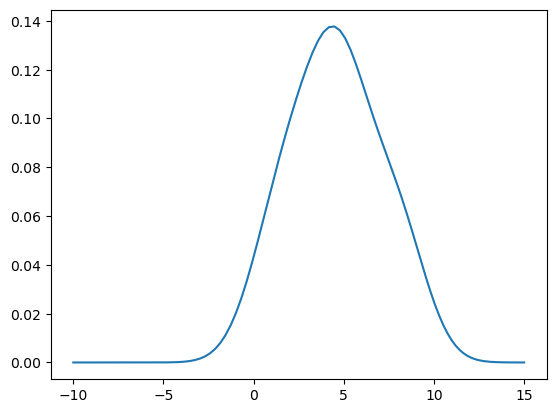

In [4]:
#Check the correctness of numerical integration
xs=np.array([1,4,2,5,6,8,9,3,5,6])-np.random.rand(10)
kdex = stats.gaussian_kde(xs)
n = 128 # Number of points
a, b = -10, 15  # Interval [a, b]
p, w = gauss_legendre(n, a, b)
print(f'Integral of pdf:{(kdex(p)*w).sum()}')#This should be very close to 1!!!
plt.plot(p,kdex(p))

In [5]:
#Check the correctness of multi_dim numerical integration
X=np.random.rand(100,3)
lower=X.min(0)-1
upper=X.max(0)+1
Gauss_points_weights,_=GLJointNW_general(N=[32,32,32],Lower=lower, Upper=upper)
Jkde=stats.gaussian_kde(X.T)
print(f'Integral of joint distribution:{(Jkde(Gauss_points_weights[:,:-1].T)*Gauss_points_weights[:,-1]).sum()}')

Integral of joint distribution:0.9999999988018645


# Calculation for joint entropy

In [6]:

num_data_points=100
xs = np.linspace(-10,10,num_data_points)
ys=np.sin(xs)+0.5*np.random.rand(num_data_points)
joint=np.hstack([xs.reshape(-1,1),ys.reshape(-1,1)])

lower=joint.min(0)
upper=joint.max(0)
buffer=0.3*(upper-lower)
Gauss_points_weights,GLpw=GLJointNW_general(N=[256,256],Lower=lower-buffer, Upper=upper+buffer)

xkde=stats.gaussian_kde(xs)
ykde=stats.gaussian_kde(ys)
jkde = stats.gaussian_kde(joint.T)

pxy_cont = jkde(Gauss_points_weights[:,:-1].T)

hxy=GL_entropy(pxy_cont,Gauss_points_weights[:,-1],e=1e-12)



In [7]:
# Function for calculating joint Entropy
def Joint_Entropy(joint,buffer_coefficient=0.3,n=64):
    """
    Calculate the joint entropy of a given joint dataset.

    Parameters:
    - joint (numpy.ndarray): An NxD array, containing N data points each with D features.
    - buffer_coefficient (float): A coefficient to determine the buffer added to the range
                                  when calculating the joint entropy, to avoid edge effects
                                  in kernel density estimation.
    - n (int): The number of Gaussian quadrature points to use in the numerical integration.

    Returns:
    - jointh (float): The calculated joint entropy of the dataset.

    The function uses Gaussian kernel density estimation to estimate the probability density
    of the joint dataset and numerical integration to calculate the entropy.
    """
    _,D=joint.shape

    lower=joint.min(0)
    upper=joint.max(0)
    buffer=buffer_coefficient*(upper-lower)
    Gauss_points_weights,_=GLJointNW_general(N=[n for i in range(D)],Lower=lower-buffer, Upper=upper+buffer)
    jkde = stats.gaussian_kde(joint.T)

    pj = jkde(Gauss_points_weights[:,:-1].T)

    jointh=GL_entropy(pj,Gauss_points_weights[:,-1],e=1e-12)
    return jointh

def Marginal_Entropy(x,buffer_coefficient=0.3,n=64):
    """
    Calculate the marginal entropy of a single-variable dataset.

    Parameters:
    - x (numpy.ndarray): An N-element array, containing N data points of a single feature.
    - buffer_coefficient (float): A coefficient to determine the buffer added to the range
                                  when calculating the marginal entropy, to avoid edge effects
                                  in kernel density estimation.
    - n (int): The number of Gaussian quadrature points to use in the numerical integration.

    Returns:
    - hx (float): The calculated marginal entropy of the dataset.

    The function uses Gaussian kernel density estimation to estimate the probability density
    of the dataset and numerical integration to calculate the entropy.
    """
    lower=x.min()
    upper=x.max()
    buffer=buffer_coefficient*(upper-lower)
    p,w=gauss_legendre(n=n, a=lower-buffer, b=upper+buffer)
    kde=stats.gaussian_kde(x)
    px=kde(p)
    hx=GL_entropy(px,w,e=1e-12)

    return hx

def Mutual_Information(x,y,buffer_coefficient=0.3,n=64,numerical_integration=True):
    """
    Calculate the mutual information between two single-variable datasets by numerical integration.

    Parameters:
    - x, y (numpy.ndarray): Two N-element arrays, each containing N data points of a single feature.
    - buffer_coefficient (float): A coefficient to determine the buffer added to the ranges
                                  when calculating the mutual information, to avoid edge effects
                                  in kernel density estimation.
    - n (int): The number of Gaussian quadrature points to use in the numerical integration.
    - numerical_integration (bool): A flag to determine whether to calculate the mutual
                                    information using numerical integration (if True) or
                                    a direct entropy calculation method (if False).

    Returns:
    - I(x;y) (float): The calculated mutual information between the two datasets.

    The function uses Gaussian kernel density estimation to estimate the probability densities
    of each dataset and their joint dataset, followed by numerical integration to calculate
    the mutual information. If numerical_integration is False, the function uses a direct
    entropy calculation method instead.
    """
    joint=np.hstack([x.reshape(-1,1),y.reshape(-1,1)])

    lower=joint.min(0)
    #print(lower)
    upper=joint.max(0)
    #print(upper)
    buffer=buffer_coefficient*(upper-lower)
    #print(buffer)
    Gauss_points_weights,GLpw=GLJointNW_general(N=[n,n],Lower=lower-buffer, Upper=upper+buffer)
    # Assume x and y are now continuous random variables
    # We will use Gaussian KDEs to estimate their densities

    # Estimating the KDEs for x, y, and joint variables
    kdex = stats.gaussian_kde(x)
    kdey = stats.gaussian_kde(y)
    jkde = stats.gaussian_kde(joint.T)
    if numerical_integration:
        MI=GL_MI(kdex,kdey,jkde,Gauss_points_weights,e=1e-12)
    else:
        p1, w1 = GLpw[0]
        p2, w2 = GLpw[1]
        px = kdex(p1)
        py = kdey(p2)
        pxy = jkde(Gauss_points_weights[:,:-1].T)
        hx=GL_entropy(px,w1,e=1e-12)
        hy=GL_entropy(py,w2,e=1e-12)
        hxy=GL_entropy(pxy,Gauss_points_weights[:,-1],e=1e-12)
        MI=max(0, hx + hy - hxy)
    return MI

# Test for MI scale sensitivity

In [8]:
x=np.linspace(-10,10,100)+np.random.randn(100)
y=x**2+30*np.random.rand(100)
print(f'Mutual info of raw data: {Mutual_Information(x,y)}')
x_mm=(x-x.min())/(x.max()-x.min())
y_mm=(y-y.min())/(y.max()-y.min())
print(f'Max Min Normalized Mutual info: {Mutual_Information(x_mm,y_mm)}')

x_z=(x-x.mean())/x.std()
y_z=(y-y.mean())/y.std()
print(f'Max Min Normalized Mutual info: {Mutual_Information(x_z,y_z)}')

Mutual info of raw data: 0.3768526213477883
Max Min Normalized Mutual info: 0.3768526213915194
Max Min Normalized Mutual info: 0.37685262139151987


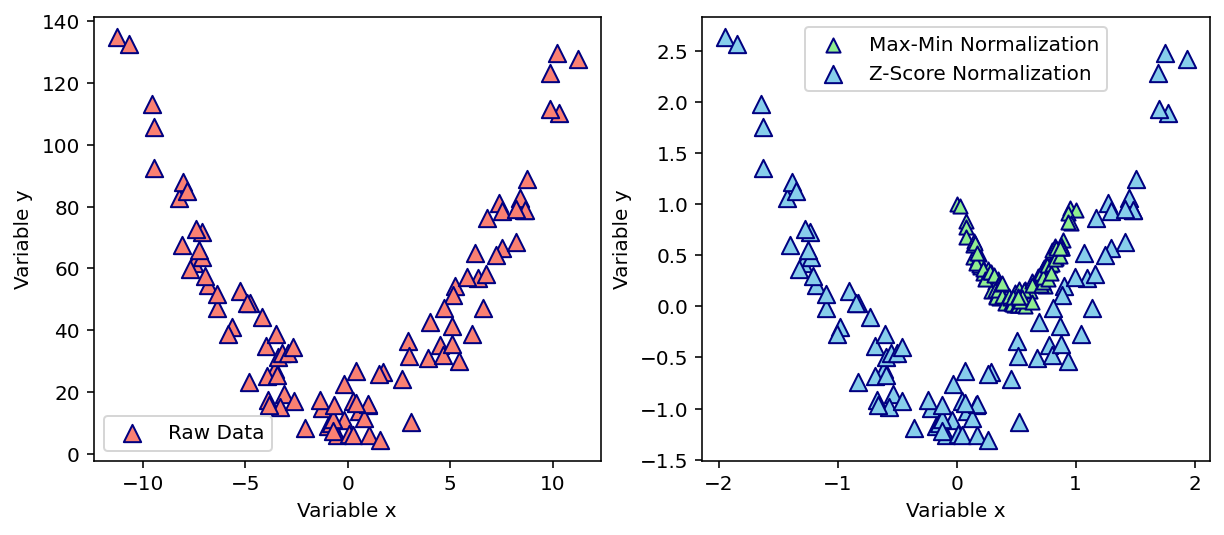

In [9]:
fig,axs=plt.subplots(1,2,figsize=(10,4),dpi=144)
#plt.figure(figsize=(4,4),dpi=288)
axs[0].scatter(x, y,s=75,marker='^',facecolor='salmon',edgecolor='navy',label='Raw Data')
axs[0].set_xlabel('Variable x')
axs[0].set_ylabel('Variable y')
axs[0].legend()
axs[1].scatter(x_mm, y_mm,s=50,marker='^',facecolor='lightgreen',edgecolor='navy',label='Max-Min Normalization')
axs[1].scatter(x_z, y_z,s=75,marker='^',facecolor='skyblue',edgecolor='navy',label='Z-Score Normalization')
axs[1].set_xlabel('Variable x')
axs[1].set_ylabel('Variable y')
axs[1].legend()

In [10]:
x=np.linspace(-10,10,100)+np.random.randn(100)
y=x**2+15*np.random.rand(100)#np.sin(x)#+
joint=np.hstack([x.reshape(-1,1),y.reshape(-1,1)])
print(f'Hx {Marginal_Entropy(x)}')
print(f'Hy {Marginal_Entropy(y)}')
print(f'Hxy {Joint_Entropy(joint)}')
print(f'Ixy {Mutual_Information(x,y,n=64)}')

Hx 4.648591606450969
Hy 7.0496603182575655
Hxy 11.420420411916057
Ixy 0.3831136153473911


In [11]:
kdex=stats.gaussian_kde(x)
kdey=stats.gaussian_kde(y)
kdej=stats.gaussian_kde(joint.T)

lower=joint.min(0)
upper=joint.max(0)
buffer=0.3*(upper-lower)
n=64
Gauss_points_weights,GLpw=GLJointNW_general(N=[n,n],Lower=lower-buffer,Upper=upper+buffer)

GL_MI(kdex,kdey,kdej,Gauss_points_weights)


0.3831136153473911

In [16]:
Marginal_Entropy(x)

4.648591606450969

# Test for calculating the mutual information

Marginal integration of X:1.0
Marginal integration of Y:1.0
Joint integration of P(X,Y):0.999
Marginal Entropy H(X):0.268
Marginal Entropy H(Y):-0.103
Joint Entropy H(X,Y):-0.574
Mutual Info by direct calculation I(X,Y):0.739
Mutual Info by function I(X,Y):0.852
Pearson corref:0.79
KL-Divergence by function D(P(X)||Q(Y)):0.461
0.268 & -0.103 & -0.574 & 0.739 & 0.852 & 0.79 & 0.783


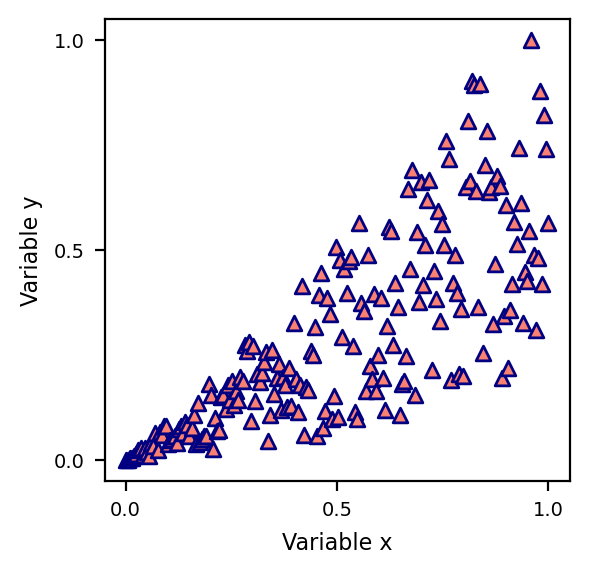

In [12]:


num_data_points=200
xs=np.random.rand(num_data_points)
ys = np.random.rand(num_data_points)#xs**2
xs = np.linspace(0,20,num_data_points)
#ys=np.cos(xs)+0.5*np.random.rand(num_data_points)
ys=xs**2+15*np.random.rand(num_data_points)*np.linspace(0,100,num_data_points)
#ys=sigmoid(xs)+0.8*np.random.rand(num_data_points)-0.4*np.sin(xs)
#ys=0.3*np.random.rand(num_data_points)+sigmoid(xs)
#p,_=skd.make_circles(num_data_points)
#xs=p[:,0]+0.2*np.random.rand(num_data_points)
#ys=p[:,1]+0.2*np.random.rand(num_data_points)
#xs=2*(xs-xs.min())/(xs.max()-xs.min())-1
#ys=2*(ys-ys.min())/(ys.max()-ys.min())-1

xs=(xs-xs.min())/(xs.max()-xs.min())
ys=(ys-ys.min())/(ys.max()-ys.min())
joint=np.hstack([xs.reshape(-1,1),ys.reshape(-1,1)])
plt.figure(figsize=(3,3),dpi=200)
plt.scatter(xs, ys,s=28,marker='^',facecolor='salmon',edgecolor='navy')
plt.xlabel('Variable x',fontsize=8)
plt.ylabel('Variable y',fontsize=8)
plt.xticks([0,0.5,1],fontsize=7)
plt.yticks([0,0.5,1],fontsize=7)
lower=joint.min(0)
upper=joint.max(0)
buffer=0.3*(upper-lower)
Gauss_points_weights,GLpw=GLJointNW_general(N=[256,256],Lower=lower-buffer, Upper=upper+buffer)
# Assume xs and ys are now continuous random variables
# We will use Gaussian KDEs to estimate their densities

# Estimating the KDEs for xs, ys, and joint variables
kdex = stats.gaussian_kde(xs)
kdey = stats.gaussian_kde(ys)
jkde = stats.gaussian_kde(joint.T)

p1, w1 = GLpw[0]
p2, w2 = GLpw[1]
px_cont = kdex(p1)
py_cont = kdey(p2)
pxy_cont = jkde(Gauss_points_weights[:,:-1].T)
hx=GL_entropy(px_cont,w1,e=1e-12)
hy=GL_entropy(py_cont,w2,e=1e-12)
hxy=GL_entropy(pxy_cont,Gauss_points_weights[:,-1],e=1e-12)
print(f'Marginal integration of X:{round((px_cont*w1).sum(),3)}')
print(f'Marginal integration of Y:{round((py_cont*w2).sum(),3)}')
print(f'Joint integration of P(X,Y):{round((pxy_cont*Gauss_points_weights[:,-1]).sum(),3)}')
# Mutual Information
print(f'Marginal Entropy H(X):{round(hx,3)}')
print(f'Marginal Entropy H(Y):{round(hy,3)}')
print(f'Joint Entropy H(X,Y):{round(hxy,3)}')
print(f'Mutual Info by direct calculation I(X,Y):{round(hx+hy-hxy,3)}')
print(f'Mutual Info by function I(X,Y):{round(GL_MI(kdex,kdey,jkde,Gauss_points_weights,e=1e-12),3)}')
print(f'Pearson corref:{round(np.corrcoef(joint.T)[0,1],2)}')
print(f'KL-Divergence by function D(P(X)||Q(Y)):{round(GL_KLD(kdex,kdey,p1,w1),3)}')
#print(f'{round(hx,3)} & {round(hy,3)} & {round(hxy,3)} & {round(((hx+hy-hxy)+GL_MI(kdex,kdey,jkde,Gauss_points_weights,e=1e-12))/2,3)}  & {round(np.corrcoef(joint.T)[0,1],2)} & {round(pair_wise_DC2(xs,ys)[0].item(),3)}'   )
print(f'{round(hx,3)} & {round(hy,3)} & {round(hxy,3)} & {round(hx+hy-hxy,3)} & {round(GL_MI(kdex,kdey,jkde,Gauss_points_weights,e=1e-12),3)} & {round(np.corrcoef(joint.T)[0,1],2)} & {round(pair_wise_DC2(xs,ys)[0].item(),3)}'   )

In [28]:
Mutual_Information(xs,ys,n=64)
Joint_Entropy(joint,n=64)

6.0507671843371

# Test for covariance approximation entropy

Marginal integration of X:1.0
Marginal integration of Y:1.0
Joint integration of P(X,Y):1.0


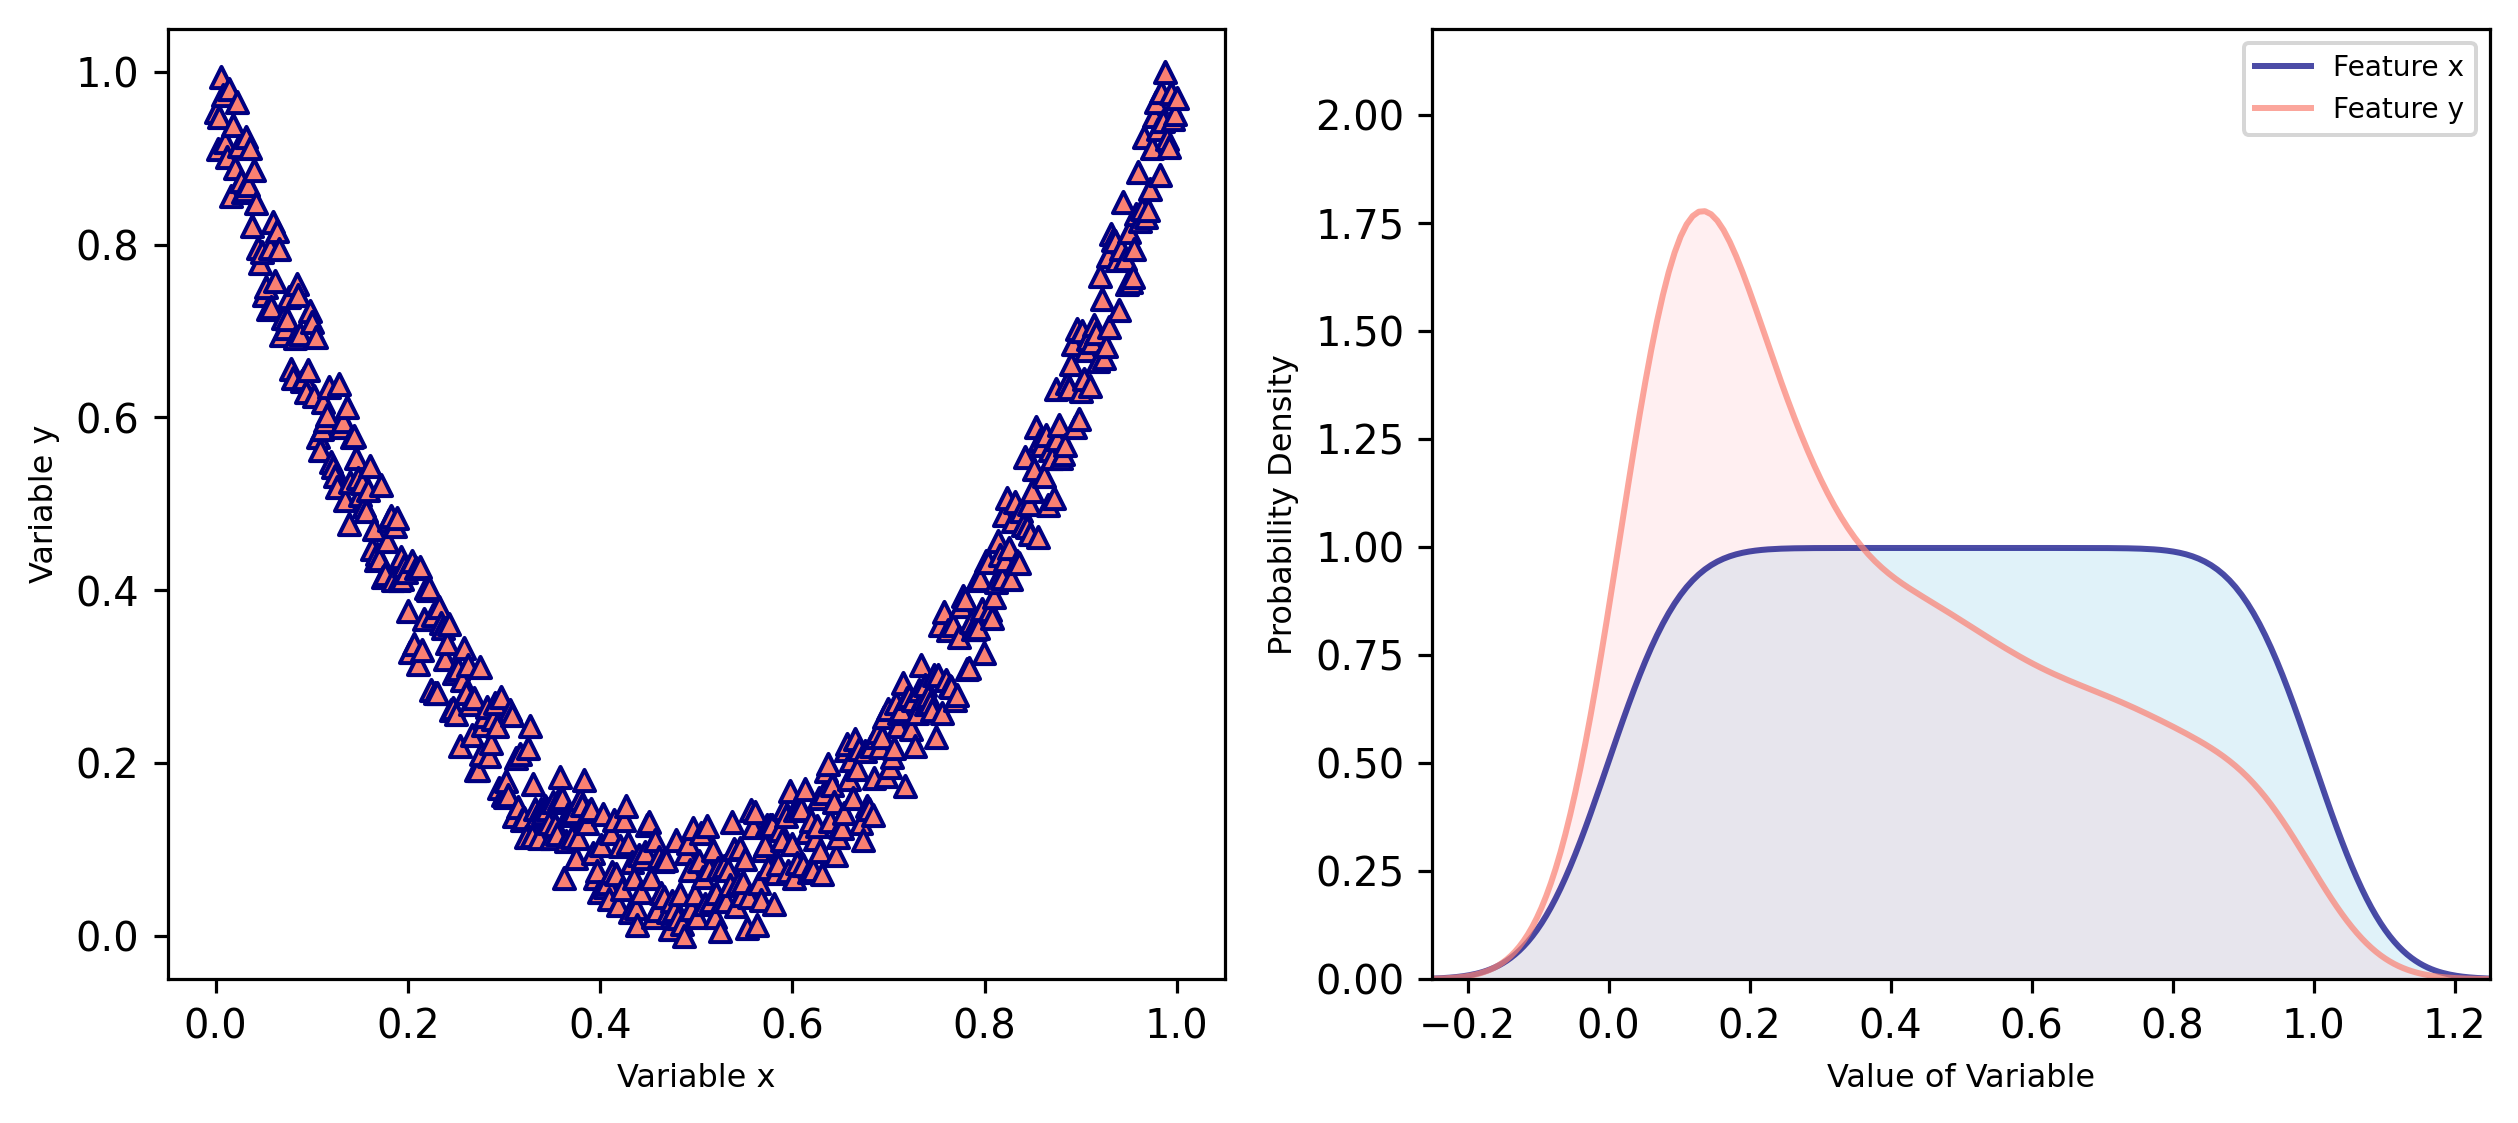

In [20]:


num_data_points=500
#xs=np.random.rand(num_data_points)
#ys = np.random.rand(num_data_points)#xs**2
xs = np.linspace(-10,10,num_data_points)
#ys=np.sin(xs)+0.5*np.random.rand(num_data_points)
ys=xs**2+15*np.random.rand(num_data_points)#*np.linspace(0,1000,num_data_points)
#ys=sigmoid(xs)+0.8*np.random.rand(num_data_points)-0.4*np.sin(xs)
#ys=xs*2+3*np.random.rand(num_data_points)#+sigmoid(xs)
#p,_=skd.make_circles(num_data_points)
#xs=p[:,0]
#ys=p[:,1]
#xs=2*(xs-xs.min())/(xs.max()-xs.min())-1
#ys=2*(ys-ys.min())/(ys.max()-ys.min())-1
xs=(xs-xs.min())/(xs.max()-xs.min())
ys=(ys-ys.min())/(ys.max()-ys.min())
joint=np.hstack([xs.reshape(-1,1),ys.reshape(-1,1)])

lower=joint.min(0)
upper=joint.max(0)
buffer=0.3*(upper-lower)
Gauss_points_weights,GLpw=GLJointNW_general(N=[256,256],Lower=lower-buffer, Upper=upper+buffer)
# Assume xs and ys are now continuous random variables
# We will use Gaussian KDEs to estimate their densities

# Estimating the KDEs for xs, ys, and joint variables
kdex = stats.gaussian_kde(xs)
kdey = stats.gaussian_kde(ys)
jkde = stats.gaussian_kde(joint.T)

p1, w1 = GLpw[0]
p2, w2 = GLpw[1]
px_cont = kdex(p1)
py_cont = kdey(p2)
pxy_cont = jkde(Gauss_points_weights[:,:-1].T)
hx=GL_entropy(px_cont,w1,e=1e-12)
hy=GL_entropy(py_cont,w2,e=1e-12)
hxy=GL_entropy(pxy_cont,Gauss_points_weights[:,-1],e=1e-12)
f_MI=GL_MI(kdex,kdey,jkde,Gauss_points_weights,e=1e-12)
print(f'Marginal integration of X:{round((px_cont*w1).sum(),3)}')
print(f'Marginal integration of Y:{round((py_cont*w2).sum(),3)}')
print(f'Joint integration of P(X,Y):{round((pxy_cont*Gauss_points_weights[:,-1]).sum(),3)}')


# Create a figure and a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, dpi=288, figsize=(9, 4))

# First subplot for the KDE plots
axs[0].scatter(xs, ys,s=28,marker='^',facecolor='salmon',edgecolor='navy')
axs[0].set_xlabel('Variable x',fontsize=8)
axs[0].set_ylabel('Variable y',fontsize=8)

labelx=r'Feature x'# +r'$k_x$='+f'{round(stats.kurtosis(xs,fisher=True),2)}'
labely=r'Feature y'# +r'$k_y$='+f'{round(stats.kurtosis(ys,fisher=True),2)}'
# Second subplot for the scatter plot
axs[1].plot(p1, px_cont, label=labelx,color='navy',alpha=0.7)
axs[1].fill_between(p1,px_cont,facecolor='skyblue',alpha=0.25)
axs[1].plot(p2, py_cont, label=labely,color='salmon',alpha=0.7)
axs[1].fill_between(p2, py_cont,facecolor='pink',alpha=0.25)
axs[1].set_xlabel('Value of Variable',fontsize=8)
axs[1].set_ylabel('Probability Density',fontsize=8)
axs[1].legend(fontsize=7)
axs[1].set_xlim([-0.25,1.25])
axs[1].set_ylim([0,2.2])
plt.tight_layout()  # Adjust the layout to make room for the elements
plt.show()

In [21]:
hx_a,hy_a,hxy_a=[H_approx(xs),H_approx(ys),H_approx(joint)]
Qn=np.array([hx,hy,hxy,(max(0, hx + hy - hxy)+f_MI)/2])
Qa=np.array([hx_a,hy_a,hxy_a,max(0.0, hx_a + hy_a - hxy_a)])
pd=np.abs((Qa-Qn)/Qn)*100
print(f'The numerical integration: {round(hx,3)} & {round(hy,3)} & {round(hxy,3)} & {round((max(0, hx + hy - hxy)+f_MI)/2,3)}')
print(f'The Covariance Approximation: {round(hx_a,3)} & {round(hy_a,3)} & {round(hxy_a,3)} & {round(max(0.0, hx_a + hy_a - hxy_a),3)}')
print(f'The Percentage Difference: {round(pd[0],2)}\% & {round(pd[1],2)}\% & {round(pd[2],2)}\% & {round(pd[3],2)}\%')

The numerical integration: 0.22 & 0.075 & -0.163 & 0.523
The Covariance Approximation: 0.259 & 0.191 & 0.45 & 0.0
The Percentage Difference: 17.66\% & 154.84\% & 375.72\% & 99.99\%


In [25]:
#Transfer entropy
y=np.linspace(1,20,20)
tau=2
t=2
#
t_=t-1
# Create lagged time series for Y (target)
y_future = y[t_+tau:]  # Y(t+tau)
y_past = y[t_:-tau]   # Y(t)
print(y)
print(y_past)
print(y_future)
kde=stats.gaussian_kde(y_past)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.]
[ 4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.]


In [136]:
p,w=gauss_legendre(128,a=6,b=22)

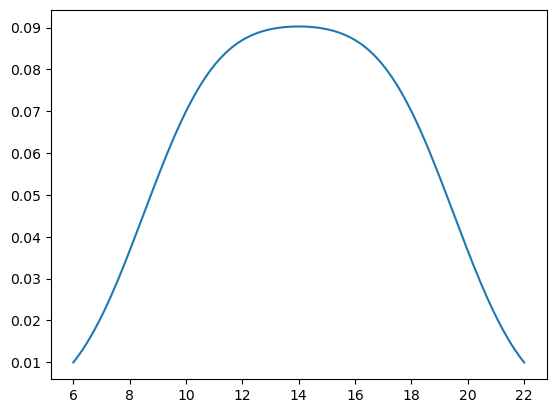

In [114]:
plt.plot(p,kde(p))

In [ ]:

xs = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1])
ys = np.array([0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1])
joint=np.hstack([xs.reshape(-1,1),ys.reshape(-1,1)])

# Assume xs and ys are now continuous random variables
# We will use Gaussian KDEs to estimate their densities

# Estimating the KDEs for xs, ys, and joint variables
kdex_cont = stats.gaussian_kde(xs)
kdey_cont = stats.gaussian_kde(ys)
jkde_cont = stats.gaussian_kde(joint.T)



# Define the support range for the variables
# Since xs and ys are between 0 and 1, we can use a range that captures the majority of the density
support_range = np.linspace(-2, 2, 3000)

# Estimate the densities using the KDEs over the support range
px_cont = kdex_cont(support_range)
py_cont = kdey_cont(support_range)


# Calculate the marginal entropies
hx_cont = entropy_marginal(px_cont, support_range)
hy_cont = entropy_marginal(py_cont, support_range)
# Recalculate the joint density on the grid


# We need to generate a grid for the joint KDE
support_grid_x, support_grid_y = np.meshgrid(support_range, support_range, indexing='ij')
support_grid = np.vstack([support_grid_x.ravel(), support_grid_y.ravel()])

# Recalculate the joint density on the grid
pxy_cont = jkde_cont(support_grid).reshape(support_grid_x.shape)

# Now we can correctly compute the joint entropy
joint_hxy = entropy_joint(pxy_cont, support_range, support_range)#-np.trapz(np.trapz(pxy_cont * np.log(pxy_cont), support_range, axis=0), support_range)

# And we recalculate the conditional entropy of Y given X
hyx_cont = joint_hxy - hx_cont
hxy_cont = joint_hxy - hy_cont
hx_cont,hy_cont, joint_hxy, hyx_cont,hxy_cont
#Discrete Entropy
# Calculate the frequencies
freq_table = np.zeros((2, 2))

# Count the occurrences for each combination of X and Y
for (x_val, y_val) in zip(xs, ys):
    freq_table[x_val, y_val] += 1

# Normalize the frequency table to get joint probabilities P(X,Y)
joint_prob = freq_table / np.sum(freq_table)

# Marginal probabilities P(X)
px = np.sum(joint_prob, axis=1)

# Calculate conditional probabilities P(Y|X) and conditional entropy H(Y|X)
conditional_entropy = 0
for x in range(2):
    for y in range(2):
        # Make sure to avoid log of zero by checking if the joint_prob is non-zero
        if joint_prob[x, y] > 0:
            conditional_entropy -= joint_prob[x, y] * np.log2(joint_prob[x, y] / px[x])

conditional_entropy



In [41]:
seqs=[1,2,3,4]
[[seqs[i],seqs[j]] for i in range(len(seqs)) for j in range(i+1,len(seqs))]

[[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]